# get .npy

## import libary

In [1]:
import os
import pickle

import librosa
import numpy as np

from tqdm.auto import tqdm

## define class

In [2]:
class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal

In [3]:
class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array

In [4]:
class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a time-series signal."""

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram+1e-6)
        return log_spectrogram

In [5]:
class StandardScaler:
    """StandardScaler use mean std normalisation to an array"""

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def normalise(self, array):
        norm_array = ((array - self.mean) / (self.std+1e-6))
        return norm_array
    
    def denormalise(self, norm_array):
        array = (norm_array*self.std) + self.mean
        return array

In [5]:
# Change to StandardScaler
# class MinMaxNormaliser:
#     """MinMaxNormaliser applies min max normalisation to an array."""

#     def __init__(self, min_val, max_val):
#         self.min = min_val
#         self.max = max_val

#     def normalise(self, array):
#         norm_array = (array - array.min()) / (array.max() - array.min())
#         norm_array = norm_array * (self.max - self.min) + self.min
#         return norm_array

#     def denormalise(self, norm_array, original_min, original_max):
#         array = (norm_array - self.min) / (self.max - self.min)
#         array = array * (original_max - original_min) + original_min
#         return array

In [6]:
class Saver:
    """saver is responsible to save features, and the mean std values."""

    def __init__(self, feature_save_dir, mean_std_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.mean_std_values_save_dir = mean_std_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)
        return save_path

    def save_mean_std_values(self, mean_std_values):
        save_path = os.path.join(self.mean_std_values_save_dir,
                                 "mean_std_values.pkl")
        self._save(mean_std_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path

In [7]:
class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.mean_std_values = {}
        self.tmp = None
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in tqdm(files):
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                # print(f"Processed file {file_path}")

    def _process_file(self, file_path):
        feature = self._extract_feature(file_path)
        norm_feature = self.normaliser.normalise(feature)
        save_path = self.saver.save_feature(norm_feature, file_path)
        # self._store_mean_std_value(save_path, np.mean(feature, axis=-1), np.std(feature, axis=-1))
        
    def compute_mean_std(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in tqdm(files):
                file_path = os.path.join(root, file)
                feature = self._extract_feature(file_path)
                if self.tmp is None:
                    # if mean_std_values have not initalized
                    feat_dim = feature.shape[0]
                    self.tmp = {
                        "sigma_x": np.zeros([feat_dim, 1]),  # dim (feat_dim, time)
                        "sigma_x2": np.zeros([feat_dim, 1]),
                        "N": 0
                    }
                self._update_stat(feature)
        self.mean_std_values["mean"] = self.tmp["sigma_x"] / self.tmp["N"]
        self.mean_std_values["std"] = np.sqrt(
            self.tmp["sigma_x2"] / self.tmp["N"] - np.square(self.tmp["sigma_x"] / self.tmp["N"])
        )
        # accumulate sigma_x, sigma_x2, N finished
        self.saver.save_mean_std_values(self.mean_std_values)
        
        
    def _extract_feature(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        return feature
        
    def _update_stat(self, feature):
        """
        feature: (feat_dim, Time)
        Mean[X] = E[X] = \Sigma X / N
        VAR[X] = E[X^2] - E[X]^2
        """
        sigma_x = feature.sum(1, keepdims=True)
        sigma_x2 = np.square(feature).sum(1, keepdims=True)
        N = feature.shape[1]
        self.tmp["sigma_x"] += sigma_x
        self.tmp["sigma_x2"] += sigma_x2
        self.tmp["N"] += N
        

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_mean_std_value(self, save_path, mean_val, std_val):
        self.mean_std_values[save_path] = {
            "mean": mean_val,
            "std": std_val
        }

## Start preprocess processed audio files

In [8]:

ROOT = r"YOUR_WORKING_DIRECTORY_PATH"

SPECTROGRAMS_SAVE_DIR = os.path.join(ROOT, "spectrograms")
FILES_DIR = os.path.join(ROOT, "sliced_final")

MIN_MAX_VALUES_SAVE_DIR = os.path.join(ROOT, "MeanStdValue")

In [9]:
# preprocessing
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 15.04 # magic number! 1292 -> 1296
SAMPLE_RATE = 22050
MONO = True

In [10]:
# instantiate all objectsslice
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.saver = saver

preprocessing_pipeline.compute_mean_std(FILES_DIR)

100%|██████████| 17793/17793 [11:21<00:00, 26.13it/s]


In [11]:
mean_std_normaliser = StandardScaler(
    preprocessing_pipeline.mean_std_values["mean"],
    preprocessing_pipeline.mean_std_values["std"],
)

preprocessing_pipeline.normaliser = mean_std_normaliser

preprocessing_pipeline.process(FILES_DIR)

100%|██████████| 17793/17793 [22:38<00:00, 13.09it/s] 


### Check normalized array

In [112]:
spec = np.load("E:\\datasethere\\testspec\\trimed_0__1.wav.npy") # --> change this to one of your file that is normalized

<AxesSubplot:>

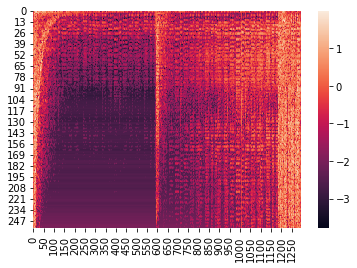

In [113]:
import seaborn as sns
sns.heatmap(spec)

# get tfrec

In [12]:
import tensorflow as tf

In [13]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _int64_array_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float32_array_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [14]:
def npy_preprocess(root,npy_path):
  file_path = os.path.join(root, npy_path)
  spectrogram = np.load(file_path)
  frequencies, time_frame = spectrogram.shape
  spectrogram = spectrogram.flatten()
  record = tf.train.Example(features=tf.train.Features(feature={
        'frequency': _int64_feature(frequencies),
        'time': _int64_feature(time_frame),
        'spectrograms':  _float32_array_feature(spectrogram),
       
    }))

  return record

In [15]:
from tqdm.auto import tqdm

In [16]:
def createTFRecord(tfrec_dir, npy_dir):
    os.makedirs(tfrec_dir, exist_ok=True)

    train_files = os.listdir(npy_dir)
    with tf.io.TFRecordWriter(os.path.join(tfrec_dir , "train.tfrecord")) as writer:
        for npy_path in tqdm(train_files):
            record = npy_preprocess(npy_dir,npy_path)
            writer.write(record.SerializeToString())

In [17]:
createTFRecord(os.path.join(ROOT, "tfrec"), SPECTROGRAMS_SAVE_DIR)

100%|██████████| 17793/17793 [36:44<00:00,  8.07it/s] 


# loading validation

In [9]:
def parse_function(example_proto):
    features = {
        'frequency': tf.io.FixedLenFeature([], tf.int64),
        'time': tf.io.FixedLenFeature([], tf.int64),
        'spectrograms': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True)
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)

    spectrogram = tf.reshape(parsed_features["spectrograms"],
                        [parsed_features["frequency"], parsed_features['time']])
    spectrogram = tf.transpose(spectrogram)
    return spectrogram

In [10]:
def get_train_data(tfrec_path):
    train_data = tf.data.TFRecordDataset(tfrec_path)\
        .shuffle(300)\
        .map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
        .batch(128)\
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        

    return train_data

In [122]:
tfrec_path = os.path.join(ROOT, "tfrec/train.tfrecord")
train = get_train_data(tfrec_path)

In [ ]:
# Check that every file in tfrec is in the same shape
for element in train:
  if element.shape[1:] != (1296, 256):
    print(element.shape)
  else:
    pass
print("done!")